# Overview
***
This fraudulent detection notebook will describe a process to identify fraudulent spirit formulas. We begin by analyzing the linear similarities in wine formulas in order to analyze spirits formulas. Fraudulent formulas will be compared to valid formulas by analyzing how closely one formula resembles propietary formula in the pre-determined dataset.

## Configure the Environment

To configure the environment, the requirements are installed. 

Tools used:
* Numpy - used for scientific computing
* Sci-kit learn - used to generate synthetic clusters
* Matplotlib - used to plot and visualize data
* Scipy - to compute distance between observations in n-dimensional space and convert the vector-form distance to to a square-form distance matrix
* Statistics - used for mean and standard deviation calculations
* Pandas - used to analyze and manipulate data
* Networkx - used to create and manipulate graphs & networks

Since we utilize AWS to store the datasets, credentials and the path to the data files are identified to allow access to the files in the S3 bucket. 

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
import statistics #mean and standard dev measurements
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams["figure.figsize"]=10,10 #configure plot size

os.chdir(os.environ['MLDIR'] + '/TestData/formula_fraud/')

## Input Datasets 

The below cell shows the input real wine data and snythetic spirits data. The wine data has 13 columns, and the syntheic spirits data has 100 columns to represent the ingredients in the wine and spirits formulas. 

**Wine Dataset:** The wine data is organizes many wine formulas into 3 groups of wines. The data comes from the following URL: https://archive.ics.uci.edu/ml/datasets/wine.

**Spirits Dataset:** Since real spirit data is propietary, and highly protected, the input dataset is synthetically created to represent formulas of 4 different types of spirits: vodka, rum, whiskey, brandy, and gin. 


In [2]:
# Read wine dataset
df_w = pd.read_csv('wine.data.csv')

col_w = []
col_w.append('group') 
col_w.append('alcohol') 
col_w.append('malic_acid') 
col_w.append('ash')
col_w.append('alcalinity')
col_w.append('magnesium')
col_w.append('phenols')
col_w.append('flavanoids')
col_w.append('nonflavanoid_phenol')
col_w.append('proanthcyanins')
col_w.append('color_intensity')
col_w.append('hue')
col_w.append('diluted_wines')
col_w.append('proline')

df_w.columns = col_w

# Read Spirits Dataset
column_names = []
column_names.append('type')
column_names.append('ethyl')
column_names.append('methonal')
column_names.append('glycerol')
column_names.append('propanol')
column_names.append('coumarin')
column_names.append('citric_acid')
column_names.append('acetaldehyde')
column_names.append('isoamyl_alcohol')
column_names.append('impurities')
for i in range(90):
    column_names.append('add_ingredient'+str(i))
    
tmp_df = pd.read_csv('spirits_train_data.csv')

df_s = pd.DataFrame(tmp_df,columns=column_names)

print('Wine Input Data')
display(df_w.head())
print('Spirits Input Data')
display(df_s.head())

Wine Input Data


,group,alcohol,malic_acid,ash,alcalinity,magnesium,phenols,flavanoids,nonflavanoid_phenol,proanthcyanins,color_intensity,hue,diluted_wines,proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


Spirits Input Data


,type,ethyl,methonal,glycerol,propanol,coumarin,citric_acid,acetaldehyde,isoamyl_alcohol,impurities,...,add_ingredient80,add_ingredient81,add_ingredient82,add_ingredient83,add_ingredient84,add_ingredient85,add_ingredient86,add_ingredient87,add_ingredient88,add_ingredient89
0,1,2.456913,1.254107,1.453961,1.536800,0.481717,0.609271,1.207817,1.654135,2.564021,...,2.156512,2.664057,1.025385,3.122031,1.626412,3.407616,2.602341,2.164176,2.047368,0.767397
1,0,0.057143,2.101622,0.884119,2.704298,1.633250,0.269017,0.843732,0.499406,1.802072,...,1.888515,1.301460,2.517023,2.156765,1.997051,-1.186179,3.323790,2.736919,4.566475,2.812993
2,3,3.134865,0.281609,3.055951,1.363279,1.876124,0.524418,2.213087,1.695274,1.013712,...,0.223124,3.525073,2.763486,0.887910,2.960680,0.632482,0.100387,-0.043816,2.195956,-0.443376
3,4,-0.641115,2.021125,2.283115,0.582500,1.482482,2.104150,1.464874,1.127270,2.235188,...,1.934240,2.055834,2.672527,1.387247,2.535532,1.044288,0.220498,1.997146,3.913699,1.431429
4,0,0.039294,1.706540,0.646560,2.821327,3.059975,2.875435,-0.467113,0.067731,1.330263,...,1.463126,1.130646,3.978197,2.829895,-0.112976,1.179699,2.003402,1.950558,0.627345,1.898897


## Training the Spirits and Wine Models
***
The cell below trains the wine and spirits data models. To train the model, the t-SNE algorithm is used to cluster n-dimensional data. Clustering n-dimensional data is a dimension reduction process. 


The t-SNE algorithm is well-suited for high-dimensional data. The algorithmn constructs a probability distribution over high-dimensional pairs in a way that similar objects have a higher likelihood of being picked while dissimilar points have an extremely small probabilitity of being picked. The algorithm can then map the n-dimensions to 2 principal components that are dominant across the n-dimensional dataset. After the N dimensional data has been mapped to 2 principal components, the data can be represented on a 2-D plot. 

This 2-D plot can be used to analyze if a new formula resembles a valid formula in our pre-determined dataset.


In [3]:
#Train wine data model
X_embedded_w = TSNE(n_components=2).fit_transform(df_w)
X_embedded_w = pd.DataFrame(X_embedded_w, columns=['x_val', 'y_val'])

X_embedded_w['type'] = 0
X_embedded_w['type'] = df_w.iloc[:,0]

X_embedded_w.loc[X_embedded_w['type'] == 1, 'type'] = 'wine_1'
X_embedded_w.loc[X_embedded_w['type'] == 2, 'type'] = 'wine_2'
X_embedded_w.loc[X_embedded_w['type'] == 3, 'type'] = 'wine_3'

# Train spirits data model
X_embedded_s = TSNE(n_components=2).fit_transform(df_s)
X_embedded_s = pd.DataFrame(X_embedded_s, columns=['x_val', 'y_val'])
X_embedded_s['type'] = 0
X_embedded_s['type'] = df_s.iloc[:,0]

X_embedded_s.loc[4, 'type'] = 5
X_embedded_s.loc[X_embedded_s['type'] == 0, 'type'] = 'vodka'
X_embedded_s.loc[X_embedded_s['type'] == 1, 'type'] = 'rum'
X_embedded_s.loc[X_embedded_s['type'] == 2, 'type'] = 'whiskey'
X_embedded_s.loc[X_embedded_s['type'] == 3, 'type'] = 'brandy'
X_embedded_s.loc[X_embedded_s['type'] == 4, 'type'] = 'gin'
X_embedded_s.loc[X_embedded_s['type'] == 5, 'type'] = 'fraud_vodka'

# Analyze Trained, and Input Data
***
The below cell shows the input real wine data, and the trained output data. The below cell also shows the synthetic spirits data, both input, and trained output data. Analysis will show that the wine data has 13 columns, and the syntheic spirits data has 100 columns. Since most of the wine formula is mostly grape of some form, the changes in the wine formula will cause a "linear" movement of the changing wine formula. If the wine formula changes in a "non-linear" method, it becomes something other than wine. 

The spirits data will show that since the wine data clusters, logically, the spirits will cluster in more of an elliptical manner. Real spirit data is propietary, and highly protected. Consequently, the input data is synthetic, and clusters artifically.

In [4]:

print('Trained Wine Data')
display(X_embedded_w)
print('Trained Spirit Data')
display(X_embedded_s)
    
    

Trained Wine Data


,x_val,y_val,type
0,8.348338,7.617149,wine_1
1,10.304304,9.187265,wine_1
2,12.412653,11.085239,wine_1
3,2.658025,1.499330,wine_1
4,12.003559,11.255432,wine_1
...,...,...,...
172,2.361162,1.788498,wine_3
173,2.710680,2.055864,wine_3
174,4.813651,3.683929,wine_3
175,5.026628,3.709014,wine_3


Trained Spirit Data


,x_val,y_val,type
0,7.185618,-1.501262,rum
1,4.009542,3.411495,vodka
2,10.652581,4.214052,brandy
3,-0.869601,3.268896,gin
4,4.943449,3.405278,fraud_vodka
...,...,...,...
95,2.360788,-1.253467,whiskey
96,0.090375,2.918143,gin
97,-1.126639,2.942787,gin
98,7.505305,-1.707234,rum


# Display Wine Data
***
This cell visulaizes the trained wine data. It shows how wine changes "linearly". If the individual wine formula would change in a perpendicular manner. It would become something other than wine. Since this real wine data clusters in a linear manner. In theory, likewise, the spirits formulas should cluster.

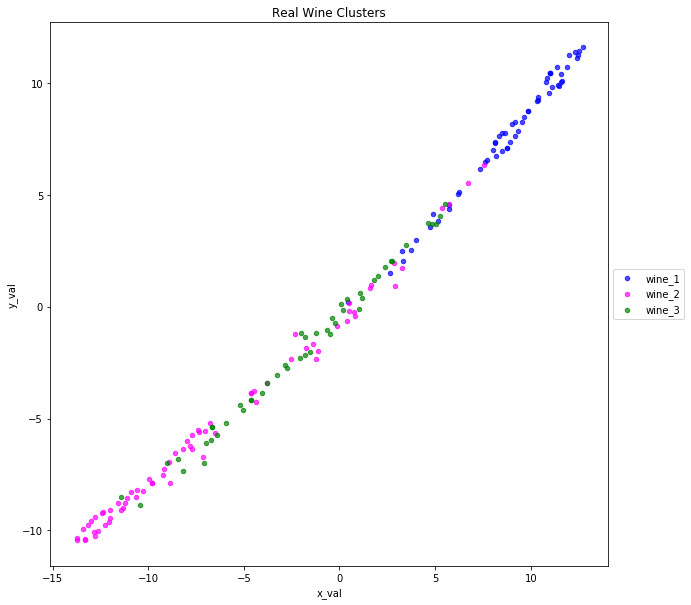

In [5]:

colors_w = {'wine_1':'blue', 'wine_2':'magenta', 'wine_3':'green', 'brandy':'yellow', 'gin':'brown'}
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grouped_w = X_embedded_w.groupby('type')
for key, group in grouped_w:
    group.plot(ax=ax, kind='scatter', x='x_val', y='y_val', label=key, color=colors_w[key], alpha=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#    plt.axis('off')
plt.title('Real Wine Clusters')
plt.show()

# Display Spirits Data
***
This cell visulaizes the trained spirits data. This visualization dramatizes how spirits would cluster. This cartoon indicates how a fraud formula, the red dot in the blue cluster, can be detected through a visual process. The red dot is very close to a valid vodka formula, indicating that the "fraud_vodka" formula is most likely a replica of the propietary formula.

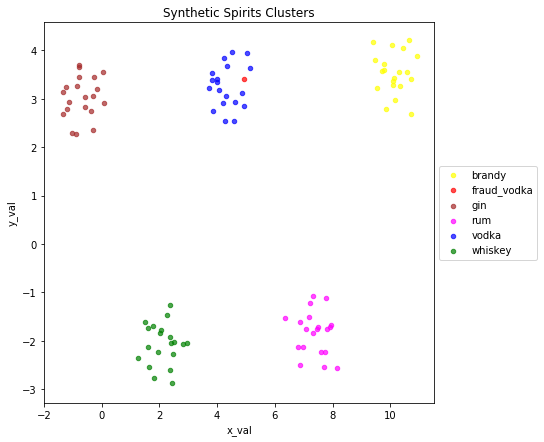

In [6]:
colors = {'vodka':'blue', 'rum':'magenta', 'whiskey':'green', 'brandy':'yellow', 'gin':'brown', 'fraud_vodka':'red'}

fig, ax = plt.subplots(1,1, figsize=(7, 7))
grouped_s = X_embedded_s.groupby('type')
for key, group in grouped_s:
    group.plot(ax=ax, kind='scatter', x='x_val', y='y_val', label=key, color=colors[key], alpha=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#    plt.axis('off')
plt.title('Synthetic Spirits Clusters')
plt.show()